In [76]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# File paths
exchange_rates_file = 'exchange_rates.xlsx'
forward_rates_file = 'forward_rates.xlsx'
interest_rates_file = 'interest_rates.xlsx'

# Load data
exchange_rates = pd.read_excel(exchange_rates_file, sheet_name='rates').set_index('Date').dropna()
forward_rates = pd.read_excel(forward_rates_file, sheet_name='rates').set_index('Date').dropna()
interest_rates = pd.read_excel(interest_rates_file, sheet_name='rates').set_index('Date').dropna()

cols = ["AUD", "CAD", "CHF", "EUR", "GBP", "JPY", "NZD", "SEK"]
exchange_rates.columns=cols
forward_rates.columns=cols

# The forward df is actually forward points, so we need to make this into forward rates.
forward_rates /= 10000
forward_rates = exchange_rates + forward_rates

interest_rates[['AUD', 'NZD']] /= 100

exchange_rates.columns = [name+"_CURNCY" for name in exchange_rates.columns]
forward_rates.columns = [name+"_CURNCY3M" for name in forward_rates.columns]
interest_rates.columns = [name+"_IR" for name in interest_rates.columns]

In [77]:
#display(exchange_rates.head(), forward_rates.head(), interest_rates.head())

In [78]:
# Merging with 'inner' join to keep only common indexes
df_merged = exchange_rates.merge(forward_rates, left_index=True, right_index=True, how='inner').merge(interest_rates, left_index=True, right_index=True, how='inner')

In [79]:
df_merged.columns.tolist()

['AUD_CURNCY',
 'CAD_CURNCY',
 'CHF_CURNCY',
 'EUR_CURNCY',
 'GBP_CURNCY',
 'JPY_CURNCY',
 'NZD_CURNCY',
 'SEK_CURNCY',
 'AUD_CURNCY3M',
 'CAD_CURNCY3M',
 'CHF_CURNCY3M',
 'EUR_CURNCY3M',
 'GBP_CURNCY3M',
 'JPY_CURNCY3M',
 'NZD_CURNCY3M',
 'SEK_CURNCY3M',
 'AUD_IR',
 'CAD_IR',
 'CHF_IR',
 'EUR_IR',
 'GBP_IR',
 'JPY_IR',
 'NZD_IR',
 'SEK_IR',
 'USD_IR']

In [90]:
def CIP_spread(USD_rf, foreign_rf, spot, forward, tau=0.25):
    """
    Computes the Covered Interest Parity (CIP) deviation/spread.

    Parameters:
    USD_rf (float or array-like): Continuously compounded USD risk-free rate (y^$_{t,τ}$).
    foreign_rf (float or array-like): Continuously compounded foreign risk-free rate (y^c_{t,τ}).
    spot (float or array-like): Spot exchange rate (s^c_t).
    forward (float or array-like): Forward exchange rate (f^c_{t,τ}).
    tau (float): Tenor of the rate (typically in years, e.g., 3-month = 0.25).

    Returns:
    float or array-like: CIP deviation/spread.
    """
    # Compute the forward premium
    rho_c_tau = (1 / tau) * (np.log(forward) - np.log(spot))

    # Compute the CIP spread
    CIP_t_tau = USD_rf - (foreign_rf - rho_c_tau)

    return CIP_t_tau

In [91]:
cols

['AUD', 'CAD', 'CHF', 'EUR', 'GBP', 'JPY', 'NZD', 'SEK']

In [94]:
df_merged.dropna(inplace=True)

In [95]:
# Creating an empty DataFrame to store CIP spreads
spreads_df = pd.DataFrame()

# Loop through each foreign currency (excluding USD)
for currency in cols:
    
    spreads_df[currency] = CIP_spread(
        USD_rf=df_merged["USD_IR"],       # USD risk-free rate
        foreign_rf=df_merged[f'{currency}_IR'], # Foreign risk-free rate
        spot=df_merged[f'{currency}_CURNCY'],       # Spot exchange rate
        forward=df_merged[f'{currency}_CURNCY3M'],     # Forward exchange rate
        tau=0.25  # 3-month period
    )

/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

invalid value encountered in log



In [88]:
spreads_df = spreads_df.loc[:'2020']

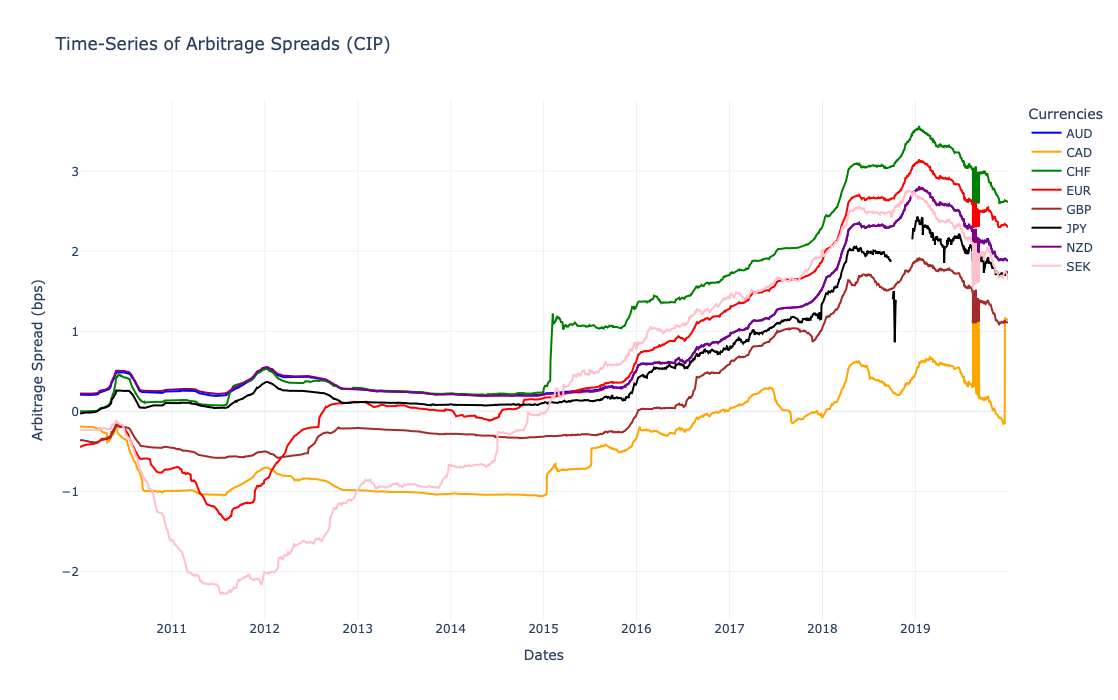

In [89]:
# Create the figure
fig = go.Figure()

# Define colors similar to the paper
colors = {
    "AUD": "blue",
    "CAD": "orange",
    "CHF": "green",
    "EUR": "red",
    "GBP": "brown",
    "JPY": "black",
    "NZD": "purple",
    "SEK": "pink"
}

# Add traces for each currency
for currency in spreads_df.columns:
    fig.add_trace(go.Scatter(
        x=spreads_df.index,
        y=spreads_df[currency],
        mode='lines',
        name=currency,
        line=dict(color=colors.get(currency, "gray"))  # Default gray if not found
    ))

# Update layout to match the paper's style
fig.update_layout(
    title="Time-Series of Arbitrage Spreads (CIP)",
    xaxis_title="Dates",
    yaxis_title="Arbitrage Spread (bps)",
    template="plotly_white",
    legend_title_text="Currencies",
    width=1000,  # Set width (increase for a wider plot)
    height=700   # Set height (increase for a taller plot)
)

# Show the figure
fig.show()
